In [7]:
import pandas as pd
import numpy as np

def analyze_and_save_windows(prices, ticker="SIM", save_files=True):
    # 1. Setup
    HORIZONS = 5 * (np.arange(26) + 1)
    ret = np.diff(np.log(prices))
    scale = np.sqrt(252)
    
    all_dfs = []

    # 2. Vectorized Window Processing
    for T in HORIZONS:
        # Calculate how many full windows of size T fit in the data
        n_windows = len(ret) // T
        if n_windows == 0:
            continue
            
        # Truncate and reshape to (n_windows, T)
        # This effectively "slices" all windows at once
        windows = ret[:n_windows * T].reshape(n_windows, T)
        
        # Vectorized calculations across axis 1 (the window)
        sums = windows.sum(axis=1)
        sigmas = windows.std(axis=1, ddof=0) * scale
        z_raws = sums / np.sqrt(T / 252.0)
        
        # Create a temporary dataframe for this Horizon T
        # (Appending to a list of DFs is faster than appending dictionaries to a list)
        horizon_df = pd.DataFrame({
            "ticker": ticker,
            "date": (np.arange(1, n_windows + 1) * T),
            "T": T,
            "z_raw": z_raws,
            "sigma": sigmas
        })
        all_dfs.append(horizon_df)

    if not all_dfs:
        return None

    df = pd.concat(all_dfs, ignore_index=True)

    # 3. Filtering and De-meaning
    # Filter for finite and positive sigma in one go
    mask = np.isfinite(df['z_raw']) & np.isfinite(df['sigma']) & (df['sigma'] > 0)
    df = df[mask].copy()
    
    # Vectorized global de-meaning
    df["z"] = df["z_raw"] - df.groupby(["ticker", "T"])["z_raw"].transform("mean")
    df = df.drop(columns="z_raw").reset_index(drop=True)

    # 4. Exporting (Logic remains the same but slightly more efficient)
    if save_files:
        n = len(df) // 3
        if n > 0:
            df.iloc[:n].to_parquet("dataset_part1.parquet")
            df.iloc[n:2*n].to_parquet("dataset_part2.parquet")
            df.iloc[2*n:].to_parquet("dataset_part3.parquet")
            print(f"Saved {len(df)} windows for ticker: {ticker}")

        if len(prices) == 100000:
            pd.DataFrame({"Day": np.arange(1, len(prices) + 1), "Price": prices}).to_csv("simulated_prices.csv", index=False)
            print("Saved 100k prices to simulated_prices.csv")

    return df

In [21]:
import numpy as np

def simulate_garch_raw(lam, mu_annual, sigma_annual, num_samples=400, N=2500, S0=100, seed=42):
    """
    Simulates GARCH(1,1) process and returns raw price and volatility lists.
    
    Returns:
        tuple: (all_prices, all_vols)
    """
    trading_days = 252
    target_V_daily = (sigma_annual**2) / trading_days
    omega = target_V_daily * (1 - lam)
    
    all_prices = []
    all_vols = []
    
    # Set seed for reproducibility
    np.random.seed(seed)
    
    for s in range(num_samples):
        # Reset for each sample block
        sample_prices = [S0]
        sample_vols = []
        V = target_V_daily 

        for i in range(1, N):
            current_sigma_daily = np.sqrt(V)
            # Store annualized volatility
            sample_vols.append(current_sigma_daily * np.sqrt(trading_days))

            # Price Update
            Z = np.random.normal(0, 1)
            log_return = (mu_annual / trading_days) - 0.5 * V + current_sigma_daily * Z
            
            new_price = sample_prices[-1] * np.exp(log_return)
            if new_price < 0.01:
                new_price = 0.01 
            sample_prices.append(new_price)
            
            # Variance Update (GARCH 1,1)
            # Alpha is fixed at (1 - lam - 0.01) per your model logic
            ret_sq = ((sample_prices[-1] - sample_prices[-2]) / sample_prices[-2])**2
            V = omega + (lam * V) + ((1 - lam - 0.01) * ret_sq)

        # Align lengths: the last price update doesn't have a subsequent volatility calculated
        sample_vols.append(sample_vols[-1])
        
        # Stitch into global lists
        all_prices.extend(sample_prices)
        all_vols.extend(sample_vols)
        
    return all_prices, all_vols

# --- Usage ---
# prices, vols = simulate_garch_raw(lam=0.81, mu_annual=0.0967, sigma_annual=0.0956)
# df_analyzed = analyze_and_save_windows(prices)

In [ ]:
import numpy as np

def simulate_garch_vectorized(lam, mu_annual, sigma_annual, num_samples=400, N=2500, S0=100, seed=42):
    """
    High-performance CPU version using NumPy vectorization.
    Processes all 400 paths in parallel using array math.
    """
    trading_days = 252
    mu_daily = mu_annual / trading_days
    target_V_daily = (sigma_annual**2) / trading_days
    omega = target_V_daily * (1 - lam)
    alpha = (1 - lam - 0.01)
    
    # Initialize arrays for all samples
    prices = np.zeros((num_samples, N))
    vols = np.zeros((num_samples, N))
    
    V = np.full(num_samples, target_V_daily)
    prices[:, 0] = S0
    
    rng = np.random.default_rng(seed)
    # Pre-generate all random numbers for speed
    Z = rng.standard_normal((num_samples, N))

    for i in range(1, N):
        curr_vol = np.sqrt(V)
        # Store annualized volatility for the current step
        vols[:, i-1] = curr_vol * np.sqrt(trading_days)
        
        # Vectorized price update across all 400 samples
        log_return = mu_daily - 0.5 * V + curr_vol * Z[:, i]
        prices[:, i] = prices[:, i-1] * np.exp(log_return)
        
        # Apply price floor
        prices[:, i] = np.maximum(prices[:, i], 0.01)
        
        # Vectorized GARCH variance update
        ret_sq = ((prices[:, i] - prices[:, i-1]) / prices[:, i-1])**2
        V = omega + (lam * V) + (alpha * ret_sq)

    # Final volatility alignment
    vols[:, -1] = vols[:, -2]
    
    # Return flattened lists to match your original function signature
    return prices.flatten().tolist(), vols.flatten().tolist()

# --- Usage ---
# all_prices, all_vols = simulate_garch_vectorized(lam=0.81, mu_annual=0.0967, sigma_annual=0.0956)

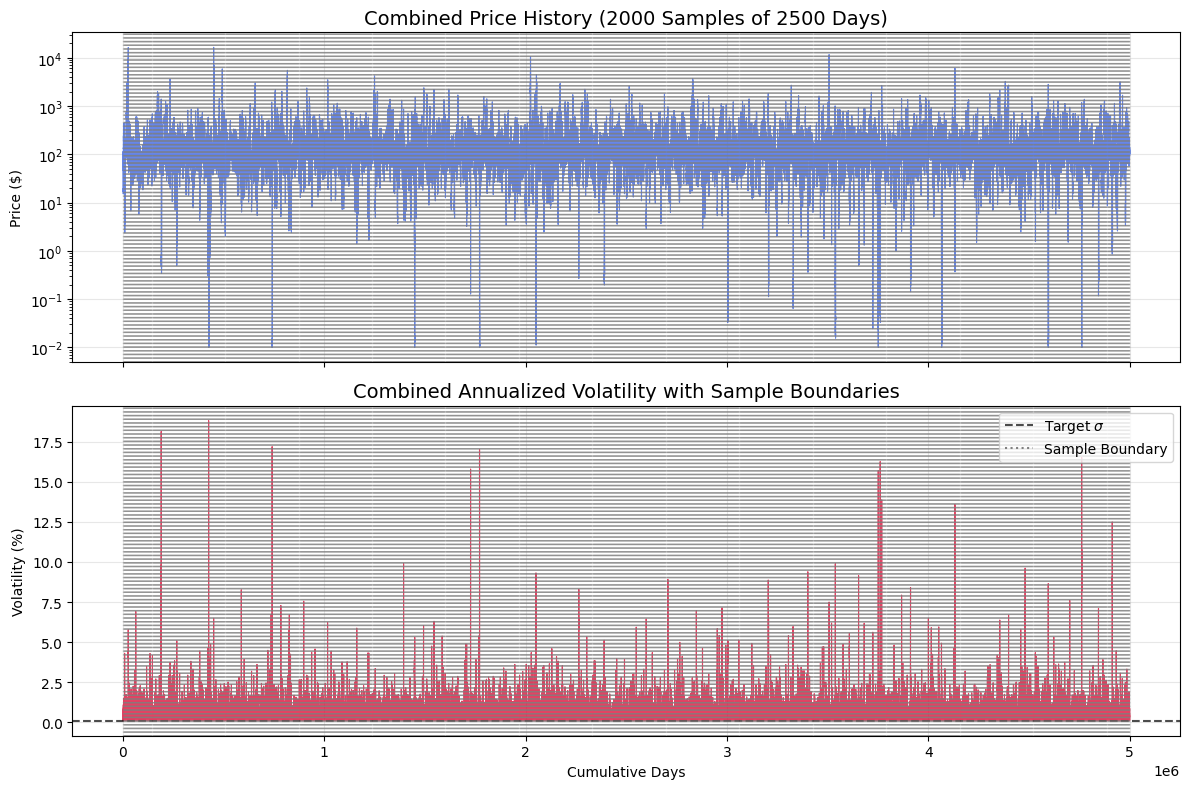

Saved 3854404 windows for ticker: SIM


,ticker,date,T,sigma,z
0,SIM,5,5,0.134730,-0.139174
1,SIM,10,5,0.077056,-0.000366
2,SIM,15,5,0.093434,0.106815
3,SIM,20,5,0.083386,0.016120
4,SIM,25,5,0.085695,-0.013970
...,...,...,...,...,...
3854399,SIM,4999410,130,0.232499,-0.019678
3854400,SIM,4999540,130,0.178023,-0.052494
3854401,SIM,4999670,130,0.235791,-0.130931
3854402,SIM,4999800,130,0.161599,0.110138


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Global Configuration ---
# N is now days per sample, num_samples is how many independent runs to stitch together
N = 2500             # Days per sample (approx 10 years)
num_samples = 2000     # Number of independent simulations

# --- 2. Model Parameters ---
sigma_annual = 0.095   
mu_annual = 0.0844        
lam = 0.8

# all_prices, all_vols = simulate_garch_raw(lam=lam, mu_annual=mu_annual, sigma_annual=sigma_annual)
all_prices, all_vols = simulate_garch_vectorized(lam=lam, mu_annual=mu_annual, sigma_annual=sigma_annual, num_samples=num_samples)

# --- 5. Visualization (Updated with Boundary Lines) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top Plot: Price History
ax1.plot(all_prices, color='royalblue', linewidth=0.8, alpha=0.8)
ax1.set_title(f"Combined Price History ({num_samples} Samples of {N} Days)", fontsize=14)
ax1.set_ylabel("Price ($)")
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Bottom Plot: Volatility History
ax2.plot(all_vols, color='crimson', linewidth=0.8, alpha=0.8)
ax2.axhline(y=sigma_annual, color='black', linestyle='--', alpha=0.7, label=r'Target $\sigma$')
ax2.set_title(r"Combined Annualized Volatility with Sample Boundaries", fontsize=14)
ax2.set_ylabel("Volatility (%)")
ax2.set_xlabel("Cumulative Days")
ax2.grid(True, alpha=0.3)

# --- ADD VERTICAL BOUNDARY LINES ---
for s in range(1, num_samples):
    boundary_day = s * N
    # Add line to Price plot
    ax1.axvline(x=boundary_day, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    # Add line to Volatility plot
    ax2.axvline(x=boundary_day, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Add a single label for the boundary lines to the legend
ax2.plot([], [], color='gray', linestyle=':', label='Sample Boundary')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# --- 6. Window Analysis ---
# Using the combined prices for the rolling analysis
display(analyze_and_save_windows(all_prices))

In [23]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

def qvar(z, s0, zoff):    # define q-variance function, parameter is minimal volatility s0 and zoff
    return (s0**2 + (z - zoff)**2 / 2)

# --- 1. Optimization Settings ---
# Defining the search space for all 3 variables
lam_range = np.linspace(0.775, 0.825, 5)       # Persistence
mu_range = np.linspace(0.0825, 0.085, 5)        # Annual Drift
sigma_range = np.linspace(0.0925, 0.0975, 5)     # Target Annual Vol

# lam_range = [0.78]       # Persistence
# mu_range = [0.0967]        # Annual Drift
# sigma_range = [0.0956]     # Target Annual Vol

best_r2 = -np.inf
best_params = None

print(f"Starting 3D Grid Search ({len(lam_range)*len(mu_range)*len(sigma_range)} combinations)...")
print("-" * 60)

for l in lam_range:
    for m in mu_range:
        for s_ann in sigma_range:
            # --- 2. Simulation Logic ---
            all_prices, _ = simulate_garch_vectorized(lam=l, mu_annual=m, sigma_annual=s_ann, num_samples=2000, N=2500)
            # all_prices = []
            # target_V_daily = (s_ann**2) / 252
            # omega = target_V_daily * (1 - l)
            
            # np.random.seed(42)

            # # Using 40 samples for a balance of speed and statistical significance
            # for s_idx in range(40): 
                
            #     sample_prices = [100]
            #     V = target_V_daily
                
            #     for _ in range(1, 2500):
            #         Z = np.random.normal(0, 1)
            #         # GARCH Price Update
            #         log_ret = (m / 252) - 0.5 * V + np.sqrt(V) * Z
            #         new_p = sample_prices[-1] * np.exp(log_ret)
            #         sample_prices.append(max(new_p, 0.01))
                    
            #         # GARCH Variance Update
            #         ret_sq = ((sample_prices[-1] - sample_prices[-2]) / sample_prices[-2])**2
            #         V = omega + (l * V) + ((1 - l - 0.01) * ret_sq)
            #         #V = max(V, 1e-6)
            #     all_prices.extend(sample_prices)

            # --- 3. Process Windows ---
            # Call your existing function (ensure it returns the DataFrame)
            df_temp = analyze_and_save_windows(all_prices, ticker=f"L{l}_M{m}_S{s_ann}", save_files = False)
            #display(df_temp)

            if df_temp is not None and not df_temp.empty:
                df_temp["var"] = df_temp.sigma**2

                zmax = 0.6  #0.6 or 1
                delz = 0.025*2
                nbins = int(2*zmax/delz + 1)
                bins = np.linspace(-zmax, zmax, nbins)         # fixed bins
                ymax = 0.35

                # create data frame with e.g. zbin = (-0.601, -0.55], z_mid, sigma
                binned = (df_temp.assign(z_bin=pd.cut(df_temp.z, bins=bins, include_lowest=True))
                    .groupby('z_bin',observed=False)
                    .agg(z_mid=('z', 'mean'), var=('var', 'mean'))
                    .dropna())

                #display(binned)
                # --- 4. Curve Fitting & R2 ---
                try:
                    if len(binned) < 5: continue # Skip if not enough data points
                    
                    popt = [0.2586, 0.0214]  # same as optimized fit to data  # for competition score should fit original parabola
                    #popt, _ = curve_fit(qvar, binned.z_mid, binned["var"], p0=[0.2, 0])
                    fitted = qvar(binned.z_mid, popt[0], popt[1])
                    
                    ss_res = np.sum((binned["var"] - fitted)**2)
                    ss_tot = np.sum((binned["var"] - binned["var"].mean())**2)
                    r2 = 1 - (ss_res / ss_tot)
                    
                    if r2 > best_r2:
                        best_r2 = r2
                        best_params = {
                            'lam': l, 'mu': m, 'sigma': s_ann, 
                            'popt': popt, 'r2': r2
                        }
                        print(f" NEW BEST >> Lam:{l:.4f} Mu:{m:.4f} Sig:{s_ann:.4f} | R2: {r2:.3f} Sigma0: {popt[0]:.3f} Zoff: {popt[1]:.3f}")
                except Exception as e:
                    continue

# --- 5. Results Summary ---
print("-" * 60)
if best_params:
    print("OPTIMIZATION COMPLETE")
    print(f"Winner Lambda: {best_params['lam']:.4f}")
    print(f"Winner Mu:     {best_params['mu']:.4f}")
    print(f"Winner Sigma:  {best_params['sigma']:.4f}")
    print(f"Max R2:        {best_params['r2']:.3f}")
else:
    print("No valid fits were found. Try increasing simulation length N or widening parameter ranges.")

Starting 3D Grid Search (125 combinations)...
------------------------------------------------------------
 NEW BEST >> Lam:0.7750 Mu:0.0825 Sig:0.0925 | R2: 0.989 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7750 Mu:0.0825 Sig:0.0938 | R2: 0.989 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7750 Mu:0.0831 Sig:0.0938 | R2: 0.990 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7875 Mu:0.0825 Sig:0.0925 | R2: 0.992 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7875 Mu:0.0825 Sig:0.0938 | R2: 0.994 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.7875 Mu:0.0825 Sig:0.0963 | R2: 0.994 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.8000 Mu:0.0825 Sig:0.0938 | R2: 0.996 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.8000 Mu:0.0825 Sig:0.0950 | R2: 0.997 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.8000 Mu:0.0838 Sig:0.0950 | R2: 0.997 Sigma0: 0.259 Zoff: 0.021
 NEW BEST >> Lam:0.8000 Mu:0.0844 Sig:0.0950 | R2: 0.997 Sigma0: 0.259 Zoff: 0.021
------------------------------------------------------------
OP